# Image Generation using Autoencoder: MNIST
- **Images**: Handwritten digits **(28x28, grayscale)**.
- **Classes**: 10 digit classes (0-9), labels are available but we don't need them!
- **Shape**: `(batch_size, 1, 28, 28)` → 1 grayscale channel.
  
![MNIST image](https://i.imgur.com/TQlKspY.png)


## 1️⃣ Dataset Class

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Define transformations (convert to tensor)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
])

# Load MNIST dataset
train_dataset = MNIST(root="./datasets", train=True, transform=transform, download=True)

# Create DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Check dataset size
print(f"Training samples: {len(train_dataset)}")


Training samples: 60000


### Let's display some images

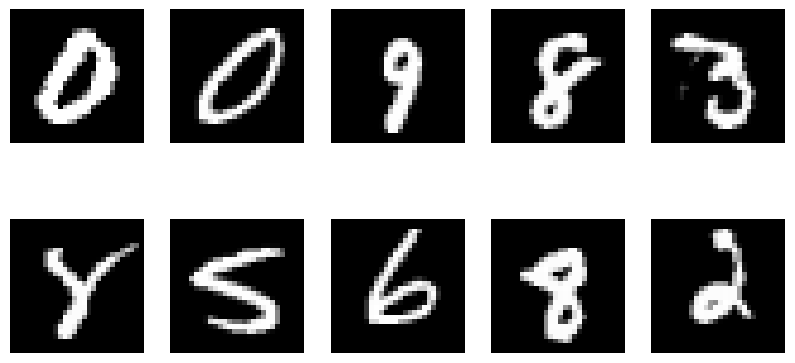

Shape of one image tensor: torch.Size([1, 28, 28])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of training data
data_iter = iter(train_loader)
images, _ = next(data_iter)  # Labels are ignored in Autoencoder

# Show images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    img = images[i].squeeze(0)  # Remove channel dimension (1, 28, 28) → (28, 28)

    ax.imshow(img.numpy(), cmap="gray")
    ax.axis("off")

plt.show()

# Show shape of one image
print("Shape of one image tensor:", images[0].shape)  # Expected: (1, 28, 28)


## 2️⃣ Model Class

In [ ]:
from types import NotImplementedType
from torch.nn.modules.linear import NonDynamicallyQuantizableLinear
import torch.nn as nn

# Define Autoencoder Model
class CNNAutoEncoder(nn.Module):
    def __init__(self, encoding_dim=8):
        super(CNNAutoEncoder, self).__init__()

        # Encoder (Feature Extraction)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2, 1),  # (28x28) → (14x14)
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, 3, 2, 1), # (14x14) → (7x7)
            nn.LeakyReLU(),
            nn.Flatten(),  # Flatten to vector
            nn.Linear(32 * 7 * 7, encoding_dim),
            nn.Tanh(),
        )

        self.fc_mu = nn.Linear(..., ...) # input and output, what are they?
        self.fc_logvar = nn.Linear(..., ...)

        # Decoder (Reconstruction)
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32 * 7 * 7),
            nn.LeakyReLU(),
            nn.Unflatten(1, (32, 7, 7)),  # Reshape back
            nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding=1),  # (7x7) → (14x14)
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 1, 3, 2, 1, output_padding=1),  # (14x14) → (28x28)
            nn.Sigmoid(),  # Normalize pixel values
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = ...
        logvar = ...
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar) # can you explain why?
        eps = torch.randn_like(...)
        return mu + ...

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x): # something is missing here for evaluation, can you spot what it is?
        mu, logvar = self.encode(x)
        z = ...
        recon_x = ...
        return recon_x, mu, logvar

In [ ]:
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + beta * kl_loss, recon_loss, kl_loss # why do we use beta?

## 3️⃣ Training and Validation Loops

We will train a model and show images instantly without a validation loop.

1️⃣ **Forward Pass** → Encode & Decode the image.  
2️⃣ **Compute Loss** → Measure the difference between input & reconstructed output.  
3️⃣ **Backward Pass** → Adjust model parameters using backpropagation.  


In [ ]:
from tqdm import tqdm    # Shows progress bar

# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device, beta=1.0):
    model.train()  # Set model to training mode
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0

    for images, _ in tqdm(dataloader):  # Ignore labels since Autoencoders don't use them
        images = images.to(device)

        reconstructions, mu, logvar = model(images)  # Forward pass (encoder + decoder)
        ... = vae_loss(reconstructions, images, mu, logvar, beta)

        optimizer.zero_grad()  # Reset gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()
        total_recon_loss += recons_loss.item()
        total_kl_loss += kl_loss.item()

    avg_loss = total_loss / len(dataloader)
    avg_recon_loss = total_recon_loss / len(dataloader.dataset)
    avg_kl_loss = total_kl_loss / len(dataloader.dataset)
    return avg_loss, avg_recon_loss, avg_kl_loss  # No accuracy since it's not classification


## 4️⃣ Running Training

Unlike classification, Autoencoders use **MSE Loss** to compare the reconstructed image with the input.


In [ ]:
import torch.optim as optim


# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNAutoEncoder(encoding_dim=8).to(device)

# Print model summary
print(model)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Measure reconstruction quality
optimizer = optim.AdamW(model.parameters(), lr=1e-4)  # AdamW optimizer
num_epochs = 2 # Number of epochs

# Store losses for plotting
train_losses = []
recon_losses = []
kl_losses = []

# Training loop
for epoch in range(num_epochs):
    train_loss, recon_loss, kl_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)

    train_losses.append(train_loss)
    recon_losses.append(recon_loss)
    kl_losses.append(kl_loss)

    print(f"Epoch {epoch+1:2d}/{num_epochs} | "
          f"Total Loss: {train_loss:.4f} | "
          f"Recon: {recon_loss:.4f} | "
          f"KL: {kl_loss:.4f}")

CNNAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1568, out_features=8, bias=True)
    (8): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Tanh()
  )
  (fc_mu): Linear(in_features=8, out_features=8, bias=True)
  (fc_logvar): Linear(in_features=8, out_features=8, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=1568, bias=True)
    (1): BatchNorm1d(1568, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)


100%|██████████| 938/938 [00:11<00:00, 85.20it/s]


Epoch  1/2 | Total Loss: 8966.9235 | Recon: 139.4514 | KL: 0.7315


100%|██████████| 938/938 [00:11<00:00, 83.79it/s]

Epoch  2/2 | Total Loss: 4153.0111 | Recon: 63.5150 | KL: 1.4104


### Plot loss and some predictions

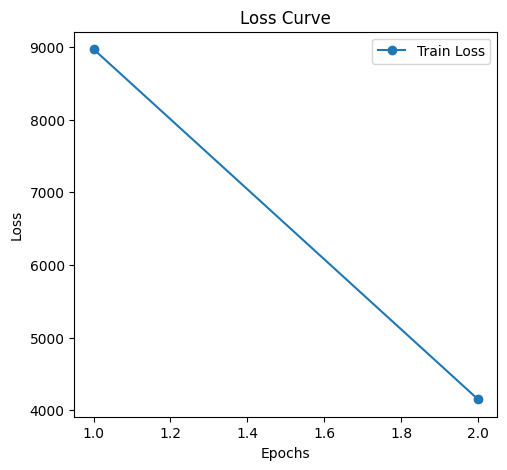

In [ ]:
import matplotlib.pyplot as plt

# Plot loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.show()

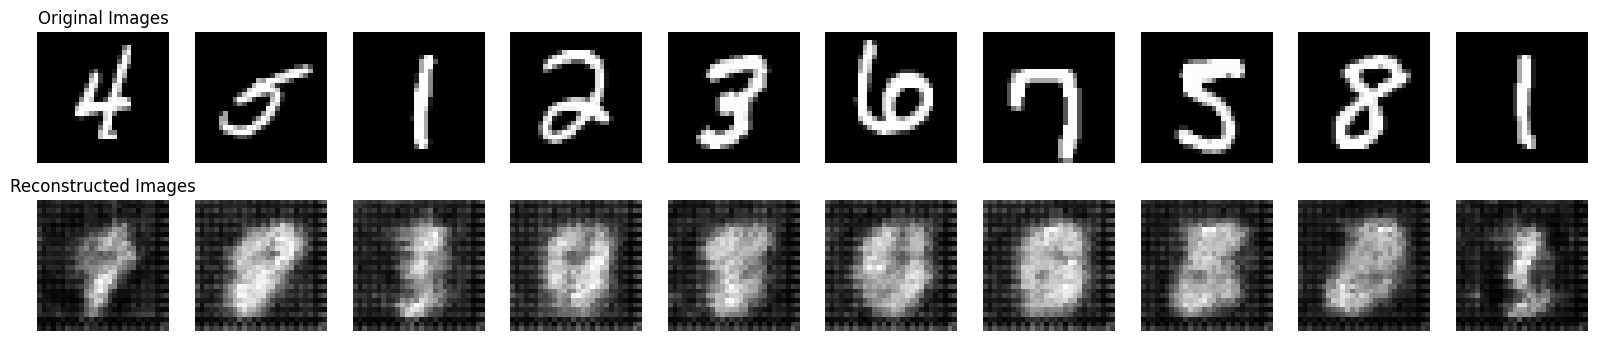

In [ ]:
import matplotlib.pyplot as plt

# 🔹 Function to Display Original vs. Reconstructed Images
def show_original_vs_reconstructed(model, dataloader, device, num_images=10):
    model.eval()  # Set to evaluation mode

    # Get a batch of images
    images, _ = next(iter(dataloader))
    images = images[:num_images].to(device)  # Select 'num_images' samples

    # Get reconstructed images
    with torch.no_grad():
        reconstructions, _, _ = model(images)
    reconstructions = reconstructions.cpu()

    # Plot original vs reconstructed images
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

    for i in range(num_images):
        # Original images (Top row)
        axes[0, i].imshow(images[i].cpu().squeeze(), cmap="gray")
        axes[0, i].axis("off")

        # Reconstructed images (Bottom row)
        axes[1, i].imshow(reconstructions[i].squeeze(), cmap="gray")
        axes[1, i].axis("off")

    axes[0, 0].set_title("Original Images", fontsize=12)
    axes[1, 0].set_title("Reconstructed Images", fontsize=12)
    plt.show()

# 🔹 Display Results
show_original_vs_reconstructed(model, train_loader, device)


Let's generate some images:

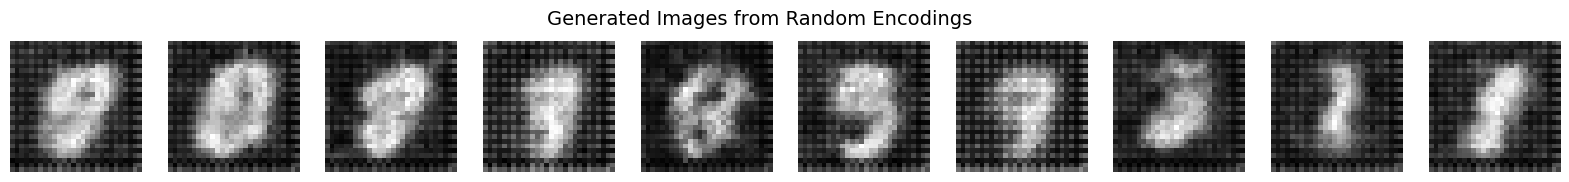

In [ ]:
import matplotlib.pyplot as plt

# 🔹 Function to Generate Images
def generate_images(model, num_images=10, encoding_dim=8):
    model.eval()  # Set to evaluation mode

    # Generate random encodings from a uniform distribution in [-1,1]
    random_encodings = ... # what shoul we use to generate random data?

    # Pass through decoder to generate images
    with torch.no_grad():
        generated_images = model.decoder(random_encodings).cpu()

    # Reshape images
    generated_images = generated_images.view(-1, 28, 28)  # Convert to 2D shape

    # Plot generated images
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i], cmap="gray")
        ax.axis("off")

    plt.suptitle("Generated Images from Random Encodings", fontsize=14)
    plt.show()

# 🔹 Generate & Display Images
generate_images(model, num_images=10, encoding_dim=8)
